# **BEFORE YOU START:  Create a copy of this notebook in your Drive!**

#  **File -> Save a copy in Drive**

If you don't do this you might edit other people's code


If you've never used Colab or Jupyter before: Shift+Enter runs the current cell.

## Please remember to check in via link or QR code.  Message me if you have problems.

**Link:** https://cglink.me/2gi/c1364304102711619

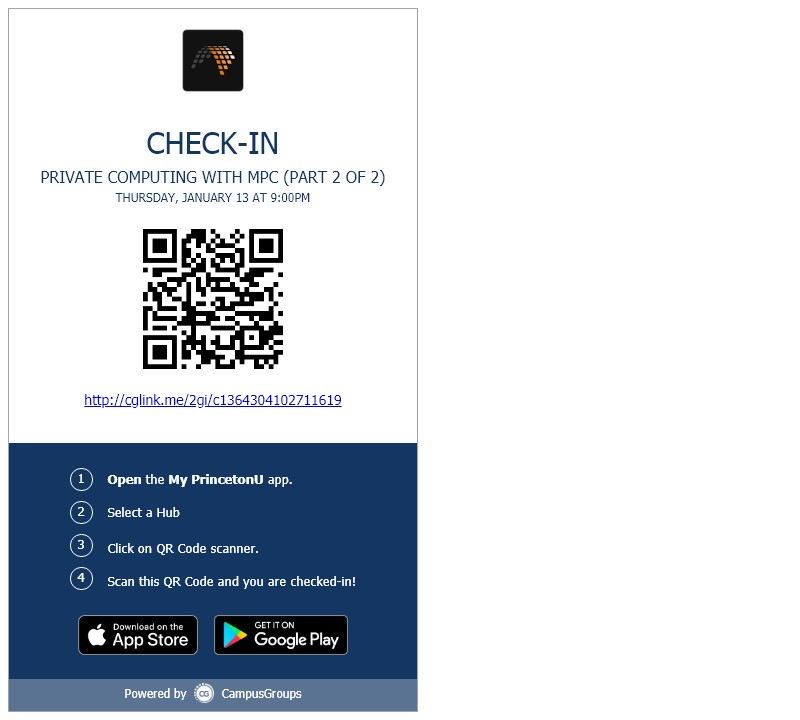

# One-time setup

In [ ]:
%cd /content
!git clone https://github.com/sarahscheffler/tinysmpc/

/content
fatal: destination path 'tinysmpc' already exists and is not an empty directory.


In [ ]:
%cd /content/tinysmpc
!git pull

/content/tinysmpc
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/sarahscheffler/tinysmpc
   764e4f5..0c90b83  master     -> origin/master
Updating 764e4f5..0c90b83
Fast-forward
 tinysmpc/shared_comparison.py | 11 +----------
 1 file changed, 1 insertion(+), 10 deletions(-)


In [ ]:
from tinysmpc import VirtualMachine, PrivateScalar, SharedScalar
from tinysmpc.fixed_point import fixed_point, float_point
from tinysmpc.finite_ring import MAX_INT64, MIN_INT64
from tinysmpc.secret_sharing import Share
from random import randrange

# Convenience functions for debugging; not "secure"
def recon(s):
    assert isinstance(s, SharedScalar), "Input to recon must be a SharedScalar"
    return s.reconstruct(VirtualMachine('tmp')).value

def shares(s):
    assert isinstance(s, SharedScalar), "Input to shares must be a SharedScalar"
    return [share.value for share in s.shares]

def val(p):
    """Value of PrivateScalar p"""
    assert isinstance(p, PrivateScalar), "Input to val must be a PrivateScalar"
    return p.value

# Note: this implementation "lazily" creates the necessary Beaver Triples and
# other similar things on the fly as they are needed, "dealing" shares to
# parties as if by a trusted third party, rather than generating them in MPC.
# Do not use this library to write deployed MPC code!
# For that, go to one of these:
# Malicious-secure garbled circuit-based: https://github.com/emp-toolkit
# Semi-honest secret sharing-based: https://github.com/multiparty/jiff/
# Malicious-secure, a behemoth: https://homes.esat.kuleuven.be/~nsmart/SCALE/


## Basic tinysmpc operations: Making parties, sharing values, and printing.

In [ ]:
# Set up virtual machines
alice = VirtualMachine('alice')
bob = VirtualMachine('bob')
charlie = VirtualMachine('charlie')

q = 9973 # the prime we will use -- could be much bigger!  Typically 64bit or larger primes are used.

In [ ]:
# Define PrivateScalars owned by a particular machine
alices_val = PrivateScalar(100, alice)

# Share a PrivateScalar into a SharedScalar by using .share(partylist, Q)
# Recomended: Always use the same prime by setting Q=q.
# Leaving Q unset will create an int64 instead.  Comparison will no longer work, though other comparisons will.
# Do NOT mix moduli by mixing int64 with shares where Q=q.
shared_val = alices_val.share([alice, bob, charlie], Q=q)

In [ ]:
# Convenience functions for debugging, NOT SECURE.
# recon(s) returns the reconstructed value of a SharedScalar.
# shares(s) returns the list of shares of a SharedScalar.
# val(p) returns the value of a PrivateScalar.
print(f"recon(shared_val) = {recon(shared_val)}")
print(f"shares(shared_val) = {shares(shared_val)}")
print(f"val(alices_val) = {val(alices_val)}")

recon(shared_val) = 100
shares(shared_val) = [5451, 4735, 9860]
val(alices_val) = 100


In [ ]:
# Reconstruct/open a share to a particular party
private_val = shared_val.reconstruct(bob)
val(private_val)

# Shared val is still around, note that after opening shares, these are no longer secret.
print(shares(shared_val))

[5451, 4735, 9860]


## Operations on SharedScalars

In [ ]:
# Addition: any combination of secret and public
a1 = shared_val + shared_val
a2 = shared_val + 5
a3 = 5 + shared_val
print(recon(a1), shares(a1))
print(recon(a2), shares(a2))
print(recon(a3), shares(a3))

200 [929, 9470, 9747]
105 [5456, 4735, 9860]
105 [5456, 4735, 9860]


In [ ]:
# Subtraction: any combination of secret and public
s1 = shared_val - shared_val
s2 = shared_val - 5
s3 = 5 - shared_val
print(recon(s1), shares(s1))
print(recon(s2), shares(s2))
print(recon(s3), shares(s3), "note that -95 % 9973 =", recon(s3) % q)

0 [0, 0, 0]
95 [5446, 4735, 9860]
9878 [4527, 5238, 113] note that -95 % 9973 = 9878


In [ ]:
# Scalar multiplication (cheap, counts as addition)
sm1 = 3 * shared_val
sm2 = shared_val * 3
print(recon(sm1), shares(sm1))
print(recon(sm2), shares(sm2))

300 [6380, 4232, 9634]
300 [6380, 4232, 9634]


In [ ]:
# Multiplication (a more expensive operation)
# Uses this algorithm as we discussed Tuesday: https://bristolcrypto.blogspot.com/2016/10/what-is-spdz-part-2-circuit-evaluation.html
m1 = shared_val * shared_val
print(recon(m1), shares(m1), "note that 100*100 % 9973 =", recon(m1) % q)

# Can also do public powers
m2 = shared_val ** 3
print(recon(m2), shares(m2))

27 [2805, 4954, 2241] note that 100*100 % 9973 = 27
2700 [1362, 8697, 2614]


In [ ]:
# Xor is available for sharings of 0 or 1.
# Has undefined behavior if used on a sharing of 2 or more.

bobs_bit = PrivateScalar(1, bob)
charlies_bit = PrivateScalar(1, charlie)
b_bit = bobs_bit.share([alice, bob, charlie], Q=q)
c_bit = charlies_bit.share([alice, bob, charlie], Q=q)

x1 = b_bit ^ c_bit
x3 = b_bit ^ 0
x2 = 1 ^ b_bit

print(recon(x1), shares(x1))
print(recon(x2), shares(x2))
print(recon(x3), shares(x3))

0 [3004, 6972, 9970]
0 [120, 1340, 8513]
1 [9854, 8633, 1460]


In [ ]:
# Greater Than (a very expensive operation!)
# Uses Algorithm 25 here: https://sharemind.cyber.ee/files/papers/sharemind_with_shamir_turban_2014.pdf
# Only works the way you would expect for numbers less than q/2.
# Only works with secret on the LHS (secret or public can go on the RHS)
c1 = shared_val > (shared_val - 1) # True
c2 = shared_val > shared_val # False
c3 = shared_val > 5
print(recon(c1), shares(c1))
print(recon(c2), shares(c2))
print(recon(c3), shares(c3))


# Note that the output of this is a secret-shared non-public bit!  We can use this to get conditionals!
c4 = shared_val > 10
var = c4*m1 + (c4 ^ 1)*m2 # equivalent to "var = m1 if c4 else m2"
print(recon(var), shares(var))

1 [4358, 2662, 2954]
0 [7020, 8292, 4634]
1 [9482, 1248, 9217]
27 [9286, 2179, 8508]


## Voting without revealing the number of counts

In [ ]:
# 0 = Bent Spoon
# 1 = Thomas Sweet

a = PrivateScalar(1, alice)   # Alice likes Thomas Sweet
b = PrivateScalar(0, bob)     # Bob likes Bent Spoon
c = PrivateScalar(0, charlie) # Charlie likes Bent Spoon

a_shared = a.share([alice, bob, charlie], Q=q)
b_shared = b.share([alice, bob, charlie], Q=q)
c_shared = c.share([alice, bob, charlie], Q=q)

total_shared = a_shared + b_shared + c_shared
ts_wins = total_shared > 1

to_ret = ts_wins.reconstruct(alice).value

if to_ret == 0:
  print("Bent Spoon wins")
elif to_ret == 1:
  print("Thomas Sweet wins")

Bent Spoon wins
